# Data Science: Capstone Project
## Segmentation and Clustering of Neighborhoods in Toronto

### 1. Neighborhoods Data (Postal Code, Borough and Neighborhood)
Source: Wikipedia, https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

#### 1.0 Preparation

In [1]:
# Import libraries
import pandas as pd
import numpy as np

#### 1.1 Data

In [2]:
# Load the data table from the website (as a list) and select the first element
df = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')[0]

# Define the column names
df.rename(columns = {'Postal Code': 'PostalCode'}, inplace = True)

# Remove the 'Not assigned' postal codes and reset the index
df = df[df['Borough'] != 'Not assigned'].reset_index(drop = True)

# Check if a given postal code appears more than once in the table
# If 'df_check_PostalCode != 0', then yes
df_check_PostalCode = sum(df['PostalCode'].value_counts()) - df.shape[0]
#print(df_check_PostalCode)

# Check if there exist a not-assigned neighborhood
# If df_check_Neighborhood != 0, then yes
df_check_Neighborhood = (df['Neighborhood'].values == '').sum()
#print(df_check_Neighborhood)

# Print the first five rows of the dataframe
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


#### 1.2 Statistics

In [3]:
# Report about the number of postal codes
print(f'\n There are {df.shape[0]} postal codes in Toronto.')


 There are 103 postal codes in Toronto.


### 2. Neighborhoods Data (Postal Code, Borough, Neighborhood, Latitude and Longitude)
Source: Cognitive Class, http://cocl.us/Geospatial_data

#### 2.0 Preparation

In [4]:
# Import libraries
import pandas as pd

#### 2.1 Data

In [5]:
# Load the data about postal code with corresponding
# latitude and longitude information
df_add = pd.read_csv('http://cocl.us/Geospatial_data')

# Define the column names
df_add.rename(columns = {'Postal Code': 'PostalCode'}, inplace = True)

# Merge the datasets (use an inner join where all matching
# instances in both dataframes are reported, intersection operator)
df_extended = df.merge(df_add, how = 'inner', on = ['PostalCode'])


#### 2.2 Statistics

In [6]:
# Report about the number of postal codes
print(f'\n There are {df_extended.shape[0]} postal codes in Toronto.')

# Report on the first postal codes
# Information: postal code, borough, neighborhood, latitude and longitute
df_extended.head()


 There are 103 postal codes in Toronto.


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


### 3. Clustering of Toronto Venue Data

#### 3.0 Preparation

In [7]:
# Import libraries
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

# Install a pip package in the current Jupyter kernel
import sys
#!{sys.executable} -m pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

# Install a pip package in the current Jupyter kernel
import sys
#!{sys.executable} -m pip install folium
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [1]:
# @hidden_cell
CLIENT_ID = '' # your Foursquare ID (removed before commiting the file to github)
CLIENT_SECRET = '' # your Foursquare Secret (removed before commiting the file to github)
VERSION = '20180605' # Foursquare API version

#print('Your credentails:')
#print('CLIENT_ID: ' + CLIENT_ID)
#print('CLIENT_SECRET:' + CLIENT_SECRET)

#### 3.1 Data of Toronto

In [10]:
# Create a dataframe of relevant data
# Borough, neighborhood, latitude and longitude
neighborhoods = df_extended.drop(columns = {'PostalCode'})

# Report on the number of boroughs and neighborhoods
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]))

# Provide the geographical coordinates of Toronto
address = 'Toronto, CA'
geolocator = Nominatim(user_agent = "toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

# Create a map of Toronto with marked neighborhoods
map_toronto = folium.Map(location = [latitude, longitude], zoom_start = 10)
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(map_toronto)
map_toronto

The dataframe has 10 boroughs and 103 neighborhoods.
The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


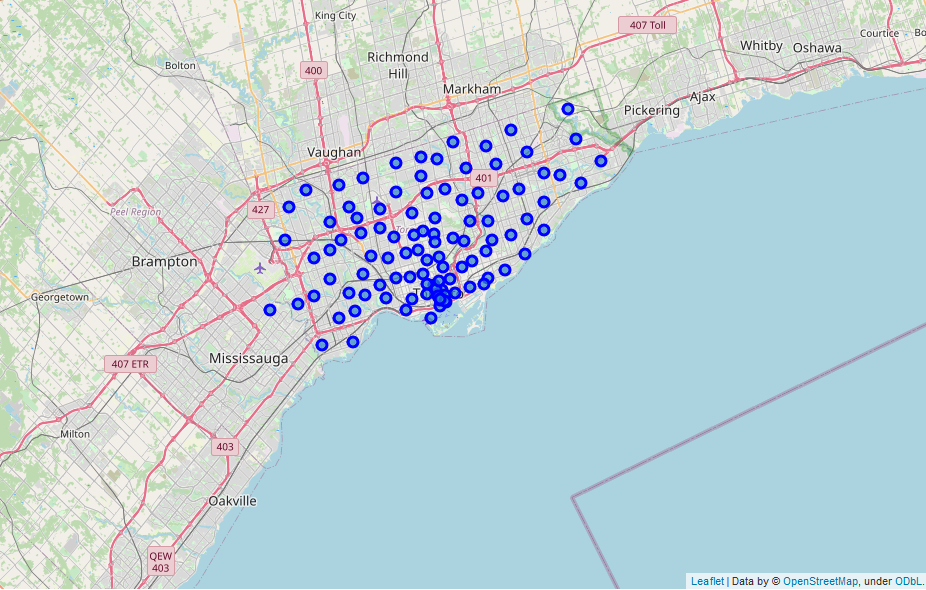

In [2]:
# For convenience, the neighborhoods are displayed as a .png
# For research reproducibility execute the codes above
from IPython.display import Image
Image("IBM_Toronto_Neighborhoods.png")

#### 3.2 Data of Borougs with 'Toronto' in their Name

In [11]:
# Select data of the boroughs that list 'Toronto' in their name
toronto_data = neighborhoods[neighborhoods['Borough'].str.contains('Toronto', case = False)].reset_index(drop = True)
LIMIT = 100

# Function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# Function that requests the data on venues
def getNearbyVenues(names, latitudes, longitudes, radius = 500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

# Data about venues in boroughts that have 'Toronto' in their name
toronto_venues = getNearbyVenues(names = toronto_data['Neighborhood'],
                                 latitudes = toronto_data['Latitude'],
                                 longitudes = toronto_data['Longitude'])

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West
High Park, The Junction South
North Toronto West
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Rosedale
Stn A PO Boxes
St. James Town,

#### 3.3 Data on Venues in the selected Neighborhoods

In [12]:
# Reporting on the dataframe size (rows: number of vanues, columns: number of variables)
print(toronto_venues.shape)

# Reporting on the number of unique venue categories
toronto_venues.groupby('Neighborhood').count()
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

# One hot encoding, add neighborhood column back to dataframe,
# move neighborhood column to the first column and grouping data
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix = "", prefix_sep = "")
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()

toronto_grouped

(1608, 7)
There are 234 uniques categories.


,Neighborhood,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Business Service,Butcher,Cable Car,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soup Place,South American Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store
0,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.017857,0.000000,0.000000,0.000000,0.000000,0.000000,0.017857,0.000000,0.017857,0.035714,0.000000,0.000000,0.00,0.017857,0.017857,0.000000,0.035714,0.000000,0.000000,0.017857,0.000000,0.000000,0.000000,0.000000,0.017857,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.035714,0.000000,0.000000,0.000000,0.035714,0.000000,0.000000,0.000000,0.000000,0.017857,0.053571,0.071429,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.017857,0.000000,0.017857,0.000000,0.00,0.017857,0.00000,0.017857,0.000000,0.0000

#### 3.4 Statistics

In [13]:
# 3.4a Print each neighborhood with top 5 most common venue types

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending = False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 5
for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue', 'freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending = False).reset_index(drop = True).head(num_top_venues))
    print('\n')

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending = False)
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10
indicators = ['st', 'nd', 'rd']
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
neighborhoods_venues_sorted = pd.DataFrame(columns = columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']
for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

----Berczy Park----
          venue  freq
0   Coffee Shop  0.07
1  Cocktail Bar  0.05
2          Café  0.04
3        Bakery  0.04
4    Restaurant  0.04


----Brockton, Parkdale Village, Exhibition Place----
            venue  freq
0            Café  0.14
1  Breakfast Spot  0.09
2     Coffee Shop  0.09
3       Pet Store  0.05
4    Climbing Gym  0.05


----Business reply mail Processing Centre----
                venue  freq
0  Light Rail Station  0.13
1         Pizza Place  0.07
2       Garden Center  0.07
3                Park  0.07
4          Restaurant  0.07


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
              venue  freq
0   Airport Service  0.18
1    Airport Lounge  0.12
2  Airport Terminal  0.12
3   Harbor / Marina  0.06
4               Bar  0.06


----Central Bay Street----
                venue  freq
0         Coffee Shop  0.17
1                Café  0.06
2  Italian Restaurant  0.06
3      Sandwich Pla

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Cheese Shop,Beer Bar,Seafood Restaurant,Bakery,Restaurant,Café,Gourmet Shop,Diner
1,"Brockton, Parkdale Village, Exhibition Place",Café,Coffee Shop,Breakfast Spot,Nightclub,Pet Store,Stadium,Bakery,Restaurant,Intersection,Italian Restaurant
2,Business reply mail Processing Centre,Light Rail Station,Auto Workshop,Comic Shop,Smoke Shop,Brewery,Farmers Market,Fast Food Restaurant,Burrito Place,Restaurant,Skate Park
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Lounge,Airport Terminal,Coffee Shop,Harbor / Marina,Rental Car Location,Sculpture Garden,Boutique,Bar,Boat or Ferry
4,Central Bay Street,Coffee Shop,Italian Restaurant,Café,Sandwich Place,Burger Joint,Department Store,Middle Eastern Restaurant,Thai Restaurant,Japanese Restaurant,Salad Place


In [14]:
# 3.4b Cluster Analysis, using kNN with 5 clusters, Statistical Results
kclusters = 5
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters = kclusters, random_state = 0).fit(toronto_grouped_clustering)
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
toronto_merged = toronto_data
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on = 'Neighborhood')
toronto_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,Coffee Shop,Bakery,Park,Pub,Café,Theater,Breakfast Spot,Restaurant,Event Space,Shoe Store
1,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0,Coffee Shop,Sushi Restaurant,Yoga Studio,Arts & Crafts Store,Juice Bar,Japanese Restaurant,Italian Restaurant,Distribution Center,Burrito Place,Beer Bar
2,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0,Clothing Store,Coffee Shop,Café,Restaurant,Middle Eastern Restaurant,Bubble Tea Shop,Japanese Restaurant,Italian Restaurant,Cosmetics Shop,Hotel
3,Downtown Toronto,St. James Town,43.651494,-79.375418,0,Coffee Shop,Café,Cocktail Bar,Gastropub,American Restaurant,Art Gallery,Clothing Store,Lingerie Store,Creperie,Seafood Restaurant
4,East Toronto,The Beaches,43.676357,-79.293031,0,Pub,Trail,Health Food Store,Women's Store,Diner,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Discount Store


In [15]:
# 3.4c Cluster Analysis, using kNN with 5 clusters, Graphical Results

# create map
map_clusters = folium.Map(location = [latitude, longitude], zoom_start = 11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html = True)
    folium.CircleMarker(
        [lat, lon],
        radius = 5,
        popup = label,
        color = rainbow[cluster - 1],
        fill = True,
        fill_color = rainbow[cluster - 1],
        fill_opacity = 0.7).add_to(map_clusters)
map_clusters

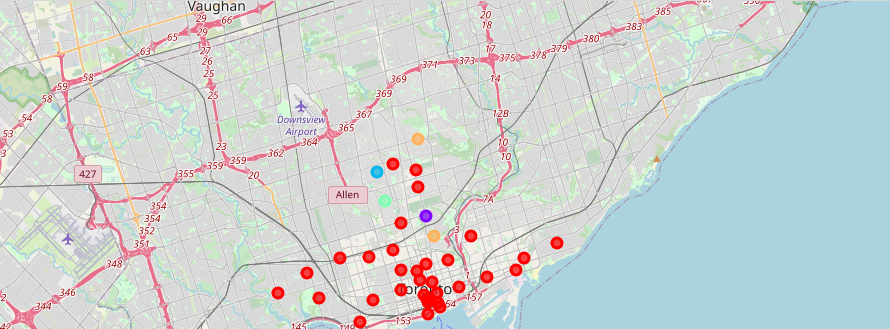

In [1]:
# For convenience, the clusters are displayed as a .png
# For research reproducibility execute the codes above
from IPython.display import Image
Image("IBM_Toronto_Neighborhoods_Clusters.png")

## Summary: Segmentation and Clustering of Neighborhoods in Toronto

### 1. Neighborhoods Data (Postal Code, Borough and Neighborhood), accomplished
### 2. Neighborhoods Data (Postal Code, Borough, Neighborhood, Latitude and Longitude), accomplished
### 3. Clustering of Toronto Venue Data, accomplished